In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
#Create paths
from pathlib import Path
#for timestamps
from datetime import datetime
#Unix style pathname pattern expansion
from glob import glob
import seaborn as sns
import os
from numpy.polynomial import Polynomial as Poly


plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Tahoma']

#PIV delta x y to plot the meshgrid correctly
DELTA_X_Y = 40
#pixel calibration in µm
PIXEL_CAL = 6.5/400
#time calibration in seconds
TIME_CAL = 0.5
#calibration to µm per minute for ux and uy matrices
CALIBRATION = (PIXEL_CAL*60)/TIME_CAL
#mmaximum color plotted in PIV in pixels per frame
MAX_PLOT = 30
#correlation distance maximum in number of cells
N_CORR = 20

In [2]:
#DEFINE FUNCTIONS
def load_data (folder):
    # This function reads the location and names files are created in Fiji
    # The list of file names and location will be used by the PIV reader
    
    # Step one: load the density data
    subdir_list_den = glob(folder+"\\*")
    name_list_den = []
    path_list_den = []
    search_word = 'density_'
    for i in range(len(subdir_list_den)):
        if ((subdir_list_den[i].find(search_word) >= 0)&(subdir_list_den[i].find('txt') >= 0)):
            #we write +4 to take into account the PIV index
            name_list_den.append(subdir_list_den[i][(len(folder)+1):len(folder)+len(search_word)+5])
            path_list_den.append(subdir_list_den[i])
    #Step two: load the PIV data
    subdir_list = glob(folder+"\\*")
    name_list = []
    path_list = []
    search_word = 'PIV_'
    for i in range(len(subdir_list)):
        if ((subdir_list[i].find(search_word) >= 0)&(subdir_list[i].find('txt') >= 0)):
            #we write +1/+5 to take into account the PIV index
            name_list.append(subdir_list[i][(len(folder)+1):len(folder)+len(search_word)+5])
            path_list.append(subdir_list[i])
    #LOAD SKELETON DATA
    #folder = 'cut00\\'
    #subdir_list_ske = glob(folder+"*")
    #name_list_ske = []
    #path_list_ske = []
    #search_word = 'skeleton_'
    #for i in range(len(subdir_list)):
    #    if ((subdir_list_ske[i].find(search_word) >= 0)&(subdir_list_ske[i].find('txt') >= 0)):
    #        #we write +4 to take into account the PIV index
    #        name_list_ske.append(subdir_list_ske[i][(len(folder)):len(folder)+len(search_word)+4])
    #        path_list_ske.append(subdir_list_ske[i])
    return name_list, path_list, path_list_den  

def  create_timestamp_path (condition_name):
    # This function creates a folder with a given condition name
    # plus a timestamp of the emoment when it was created
    dateTimeObj = datetime.now()
    timestampStr = dateTimeObj.strftime("%Y%m%d_%H_%M.%f")
    output_path = 'output\\'+condition_name+'_'+timestampStr+'\\'
    Path(output_path).mkdir(parents=True, exist_ok=True)
    return output_path

def read_PIV_density_data (name_list, path_list, path_list_den):
    # This fuction creates density and velocity arrays from PIV text files
    df = pd.read_csv(path_list[0], header=None,  delim_whitespace=True)
    df = df.loc[(df[2] != 0) | (df[3] != 0)]
    df = df[[0, 1, 2, 3,]]
    df.columns = ['x', 'y', 'ux', 'uy']
    df = df.reset_index(drop=True)
    df_array = df.to_numpy()

    # Here we define the maximul/minimum x and y positions in the PIV data
    # this serves to delimit the array size
    min_x = np.min(df_array[:, 0])
    max_x = np.max(df_array[:, 0])
    min_y = np.min(df_array[:, 1])
    max_y = np.max(df_array[:, 1])
    
    #Here we create X and Y, which are the meshgrid positions used for quiver plot
    x = np.arange(min_x, max_x, DELTA_X_Y)
    y = np.arange(min_y, max_y, DELTA_X_Y)
    X, Y = np.meshgrid(x, y)
    
    # ux_array, uy_array, density_array are filled later with velocity and density data
    # they have x, y and time dimensions
    ux_array = np.zeros((X.shape[0], X.shape[1], len(name_list)))
    uy_array = np.zeros((X.shape[0], X.shape[1], len(name_list)))
    density_array = np.zeros((X.shape[0], X.shape[1], len(name_list)))
    density_array[:]=np.nan
    
    # Here we fill up the ux_array, uy_array, density_array matrices
    # we iterate over time "i"
    for i in range(0,len(name_list)):
        df = pd.read_csv(path_list[i], header=None,  delim_whitespace=True)
        df = df.loc[(df[2] != 0) | (df[3] != 0)]
        df = df[[0, 1, 2, 3,]]
        df.columns = ['x', 'y', 'ux', 'uy']
        df = df.reset_index(drop=True)
        df_array = df.to_numpy()

        df_den = pd.read_csv(path_list_den[i], header=None,  delim_whitespace=True)
        df_array_den = df_den.to_numpy()
        # Density is normalized by its mean at tach timepoint
        df_array_den = df_array_den/np.nanmean(df_array_den)
        
        # At every timepoint "i", we iterate over all the elements to find out the X and Y positions
        # Then we fill these x and y positions in ux_array, uy_array, density_array 
        for element in np.arange(0, len(df_array)):
            x_pos = np.where(x == df_array[element, 0])
            y_pos = np.where(y == df_array[element, 1])
            ux_array[y_pos, x_pos, i] = df_array[element, 2]
            uy_array[y_pos, x_pos, i] = df_array[element, 3]
            density_array[y_pos, x_pos, i] = df_array_den[y[y_pos].astype(int), x [x_pos].astype(int)]
    # We get the correct pixel size by multiplying by CALIBRATION
    ux_array = ux_array*CALIBRATION
    uy_array = uy_array*CALIBRATION
    # We set as NaN values the ux, uy values where density is NaN
    # This might correspont to points not belonging to the cell
    ux_array[np.isnan(density_array)] = np.nan
    uy_array[np.isnan(density_array)] = np.nan
    return X, Y, ux_array, uy_array, density_array


def plot_PIV (name_list, path_list, X, Y, ux_array, uy_array, MAX_PLOT, density_array, output_path):
    # This function plots and saves PIV for each timepoint
    for i in range(0,len(name_list)):
        mag = np.sqrt((ux_array[:,:,i]*ux_array[:,:,i])+(uy_array[:,:,i]*uy_array[:,:,i]))
        #Quiver plot of ux, ux by X Y meshgrid colored by mag
        mpl.rcParams['figure.dpi']= 100
        plt.rcParams['figure.figsize'] = [4,3]
        fig, ax = plt.subplots(figsize=(7,7))
        ax.quiver(X,Y,ux_array[:,:,i],-uy_array[:,:,i], mag, alpha=0.8, cmap = 'jet',  clim=[0, MAX_PLOT], width = 0.013, headlength  =4.5)
        ax.set_title(name_list[i])
        ax.set_aspect('equal')
        ax.set_xlim(0,np.max(X)+DELTA_X_Y)
        ax.set_ylim(0,np.max(Y)+DELTA_X_Y)
        plt.gca().invert_yaxis()
        plt.savefig(output_path+name_list[i]+'.pdf')
        plt.close()
    return

def make_correlation_order_array (X, Y, ux_array, uy_array, density_array):
    # distance_matrix has (x,y,x*y) dimensions.
    # It computes the distace of all elements to a given element in µm
    distance_matrix = np.zeros((X.shape[0], X.shape[1], X.shape[0]*X.shape[1]))
    site = 0
    for x in np.arange(X.shape[0]):
        for y in np.arange(X.shape[1]):
            distances = np.sqrt(((X-X[x,y])*PIXEL_CAL)**2+((Y-Y[x,y])*PIXEL_CAL)**2)
            distance_matrix[:,:,site] = distances
            site = site + 1
    # corr_distances is a 1D vector which has the calibrated distances, ordered upto N_CORR
    # this is equivalent to (1,2^0.5,2,...)*CALIBRATION*DELTA_X_Y
    corr_distances = np.sort(np.unique(distance_matrix.flatten()))[0:N_CORR]
    # corr_matrix has (x,y,t,N_CORR) dimensions.
    # corr_matrix stores correlation values for the N_CORR closest pixels at every (x,y,t)
    corr_matrix = np.zeros((X.shape[0], X.shape[1], uy_array.shape[2], N_CORR))
    # order array stores the average cos(theta) of the 8 nearest neighbors to each pixels.
    # order_array has (x,y,t) dimensions
    order_array = np.full_like(density_array, np.nan, dtype=np.double)
    #iteration over time
    for time in np.arange(0,uy_array.shape[2]):
        mean_ux = np.nanmean(ux_array[:,:,time])
        mean_uy = np.nanmean(uy_array[:,:,time])
        # CAREFUL!!! Correct for X or Y depending on the orientation of the flow
        # We calculate the correlation only for the velocity component in the flow direction
        #U_prime is the normalized vector dimensions
        u_prime = ux_array[:,:,time] - mean_ux
        ux_cos = ux_array[:,:,time]
        uy_cos = uy_array[:,:,time]
        site = 0
        #iteration over PIV sites (x and y)
        for y in np.arange(X.shape[0]):
            for x in np.arange(X.shape[1]):
                # corr_values and order_parameter will be stored in corr_matrix and order_array
                corr_values = np.full_like(corr_distances, np.nan, dtype=np.double)
                order_parameter = np.nan
                #CORRELATION VALUES:
                if np.logical_not(np.isnan(u_prime[y,x])):
                    #iterate over the distances to find all uy values at the correct distances
                    for delta_r in np.arange(len(corr_distances)):
                        # store the velocity values at delta_r distance thanks to distance_matrix
                        # we use the index "site" to find the good location in distance_matrix
                        u_val = u_prime[distance_matrix[:,:,site] == corr_distances[delta_r]]
                        # here we get rid of NaN values in case it took pixels out of the cell
                        u_val = u_val[~np.isnan(u_val)]
                        if len(u_val)>1:
                            I = np.sign(u_prime[y,x])*np.mean(u_val)/(np.sqrt(np.mean(np.square(u_val))))
                            corr_values[delta_r] = I
                        # at distance=0 correlation=1
                        corr_values[0] = 1
                    #ORDER PARAMETER:
                    uy_order = uy_cos[np.logical_or(distance_matrix[:,:,site] == corr_distances[0],
                                                    distance_matrix[:,:,site] == corr_distances[1],
                                                    distance_matrix[:,:,site] == corr_distances[2],)]
                    ux_order = ux_cos[np.logical_or(distance_matrix[:,:,site] == corr_distances[0],
                                                    distance_matrix[:,:,site] == corr_distances[1],
                                                    distance_matrix[:,:,site] == corr_distances[2],)]
                    norm_center = np.sqrt(ux_cos[y,x]*ux_cos[y,x]+uy_cos[y,x]*uy_cos[y,x])
                    norm_order = np.sqrt(ux_order*ux_order+uy_order*uy_order)
                    cos_theta = (ux_order*ux_cos[y,x]+uy_order*uy_cos[y,x])/(norm_center*norm_order)
                    order_parameter = np.mean(cos_theta)
                #assign the 10 correlation values to the correct place in the correlation matrix
                corr_matrix[y,x,time,:] = corr_values
                order_array[y,x,time] = order_parameter
                # Iterate to a differnet site for the distance_matrix location
                site = site + 1
    return corr_matrix, corr_distances, order_array

def calculate_correlation_lengths (corr_matrix, corr_distances, density_array, output_path):
    # This function iterates over the corr_matrix (x,y,t,corr_values) and
    # assigns a correlation length (in µm) to each (x,y,t)
    
    # Define the correlation threshold, which will be used to define the correlation length
    # Correlation values span from -1 to +1
    CORR_THRESH = 0.5
    
    # Initialize corr_lengths, a matrix of (x,y,t) dimensions which will contain the 
    # correlation lenths per timepoint per position in micrometers 
    corr_lengths = np.zeros_like(density_array)
    for time in np.arange(density_array.shape[2]):
        for x in np.arange(density_array.shape[1]):
            for y in np.arange(density_array.shape[0]):
                if np.logical_not(np.isnan(density_array[y,x,time])):
                    if np.any (corr_matrix[y,x,time,:] < CORR_THRESH):
                        length = corr_distances[np.argmax(corr_matrix[y,x,time,:] < CORR_THRESH)-1]
                    else:
                        length = corr_distances[N_CORR-1]
                else:
                    length = np.nan
                corr_lengths[y,x,time] = length
    
    # Here we plot a binned histogram of the corr. length as a funtion of the actin density
    # First we define a data frame to plot in seaborn
    df = pd.DataFrame({'Density': density_array.flatten(), 'Length': corr_lengths.flatten()}).dropna()
    df['Density_bins'] = pd.cut(df['Density'], bins=15)
    # Set dpi and figure size
    mpl.rcParams['figure.dpi']= 100
    plt.rcParams['figure.figsize'] = [4,3]
    fig, ax = plt.subplots (1,1)
    fig = sns.boxplot( y=df["Length"], x=df["Density_bins"] , color='gray')
    fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.tight_layout()
    plt.savefig(output_path+'_correlation_length_density.pdf')
    
    # The function outputs a matrix of (x,y,t) dimensions with the corr. length in µm
    return corr_lengths

def plot_summary_bleb(ux_array, uy_array, density_array, corr_lengths, order_array, output_path):
    mpl.rcParams['figure.dpi']= 100
    plt.rcParams['figure.figsize'] = [5,10]
    divergence_array = np.gradient(ux_array, axis=1) + np.gradient(uy_array, axis=0)
    #Network turnover (assuming steady-state)
    ux_mean = np.nanmean(ux_array, axis=2)
    uy_mean = np.nanmean(uy_array, axis=2)
    density_mean = np.nanmean(density_array, axis=2)
    turnover_array = np.gradient(np.multiply(ux_mean, density_mean), axis=1) + np.gradient(np.multiply(uy_mean, density_mean), axis=0)
    #Network turnover (NOT assuming steady-state)
    turnover_array_not_ss = np.gradient(np.multiply(ux_array, density_array), axis=1) + np.gradient(np.multiply(uy_array, density_array), axis=0) + np.gradient(density_array, axis=2)

    #PIV SCALING
    scale = DELTA_X_Y*PIXEL_CAL
    axis_labels = np.arange(0,5*10,10)

    #axis plot
    fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(7, 1)

    mean_density = np.nanmean(density_array, axis=2)
    ax1.imshow(mean_density)
    ax1.set_yticks (axis_labels/scale-0.5)
    ax1.set_yticklabels (list(axis_labels))
    ax1.set_xticks (axis_labels[0:2]/scale-0.5)
    ax1.set_xticklabels (list(axis_labels))
    ax1.set_xlabel(r'X ($\mu$m)')
    ax1.set_title('Mean density')
    ax1.set_ylabel(r'Y ($\mu$m)')
    ax1.axis([-0.5, (ux_array.shape[1]-0.5), (ux_array.shape[0]-0.5), -0.5])

    ux_mean = np.nanmean(ux_array, axis=2)
    uy_mean = np.nanmean(uy_array, axis=2)
    mag_mean = np.sqrt(np.multiply(ux_mean, ux_mean) + np.multiply(uy_mean, uy_mean))
    x = np.arange(0, ux_array.shape[1]*scale, scale)
    y = np.arange(0, ux_array.shape[0]*scale, scale)
    xx, yy = np.meshgrid(x, y)
    ax2.quiver(xx, yy, ux_mean,-uy_mean, mag_mean, alpha=0.8, cmap='viridis', width = 0.013, headlength  =4.5) #, clim=[0, 20])
    ax2.set_aspect('equal')
    ax2.set_yticks ([-0.5*scale, 10-0.5*scale, 20-0.5*scale, 30-0.5*scale, 40-0.5*scale])
    ax2.set_yticklabels ([0,10,20,30,40])
    ax2.set_xticks ([-0.5*scale, 10-0.5*scale])
    ax2.set_xticklabels ([0,10])
    ax2.set_xlabel(r'X ($\mu$m)')
    ax2.set_title('Mean PIV')
    ax2.axis([-0.5*scale, (ux_array.shape[1]-0.5)*scale, -0.5*scale, (ux_array.shape[0]-0.5)*scale])
    ax2.set_ylim(ax2.get_ylim()[::-1])

    mean_divergence = np.nanmean(divergence_array, axis=2)
    ax3.imshow(mean_divergence,) # clim=(-10, +10))
    ax3.set_yticks (axis_labels/scale-0.5)
    ax3.set_yticklabels (list(axis_labels))
    ax3.set_xticks (axis_labels[0:2]/scale-0.5)
    ax3.set_xticklabels (list(axis_labels))
    ax3.set_xlabel(r'X ($\mu$m)')
    ax3.set_title('Mean divergence')
    ax3.axis([-0.5, (ux_array.shape[1]-0.5), (ux_array.shape[0]-0.5), -0.5])

    ax4.imshow(turnover_array, cmap='bwr', clim=(-4,+4))
    ax4.set_yticks (axis_labels/scale-0.5)
    ax4.set_yticklabels (list(axis_labels))
    ax4.set_xticks (axis_labels[0:2]/scale-0.5)
    ax4.set_xticklabels (list(axis_labels))
    ax4.set_xlabel(r'X ($\mu$m)')
    ax4.set_title('Mean turnover (S.S.)')
    ax4.axis([-0.5, (ux_array.shape[1]-0.5), (ux_array.shape[0]-0.5), -0.5])

    mean_turnover_array_not_ss = np.nanmean(turnover_array_not_ss, axis=2)
    ax5.imshow(mean_turnover_array_not_ss, cmap='bwr', clim=(-4,+4))
    ax5.set_yticks (axis_labels/scale-0.5)
    ax5.set_yticklabels (list(axis_labels))
    ax5.set_xticks (axis_labels[0:2]/scale-0.5)
    ax5.set_xticklabels (list(axis_labels))
    ax5.set_xlabel(r'X ($\mu$m)')
    ax5.set_title('Mean turnover')
    ax5.axis([-0.5, (ux_array.shape[1]-0.5), (ux_array.shape[0]-0.5), -0.5])

    mean_order = np.nanmean(order_array, axis=2)
    ax6.imshow(mean_order, clim=(-1, +1))
    ax6.set_yticks (axis_labels/scale-0.5)
    ax6.set_yticklabels (list(axis_labels))
    ax6.set_xticks (axis_labels[0:2]/scale-0.5)
    ax6.set_xticklabels (list(axis_labels))
    ax6.set_xlabel(r'X ($\mu$m)')
    ax6.set_title('Mean order param')
    ax6.axis([-0.5, (ux_array.shape[1]-0.5), (ux_array.shape[0]-0.5), -0.5])

    mean_corr_lengths = np.nanmean(corr_lengths, axis=2)
    ax7.imshow(mean_corr_lengths,) # clim=(0, +10))
    ax7.set_yticks (axis_labels/scale-0.5)
    ax7.set_yticklabels (list(axis_labels))
    ax7.set_xticks (axis_labels[0:2]/scale-0.5)
    ax7.set_xticklabels (list(axis_labels))
    ax7.set_xlabel(r'X ($\mu$m)')
    ax7.set_title('Mean corr length')
    ax7.axis([-0.5, (ux_array.shape[1]-0.5), (ux_array.shape[0]-0.5), -0.5])
    
    fig.tight_layout()
    plt.savefig(output_path+'_all_summary_bleb.pdf')
    return mean_density, ux_mean, uy_mean, mean_divergence, mean_turnover_array_not_ss, mean_order, mean_corr_lengths


C:\Users\Juanma\Anaconda3\lib\site-packages\ipykernel_launcher.py:210: RuntimeWarning: invalid value encountered in less
C:\Users\Juanma\Anaconda3\lib\site-packages\ipykernel_launcher.py:211: RuntimeWarning: invalid value encountered in less
C:\Users\Juanma\Anaconda3\lib\site-packages\ipykernel_launcher.py:210: RuntimeWarning: invalid value encountered in less
C:\Users\Juanma\Anaconda3\lib\site-packages\ipykernel_launcher.py:211: RuntimeWarning: invalid value encountered in less
C:\Users\Juanma\Anaconda3\lib\site-packages\ipykernel_launcher.py:210: RuntimeWarning: invalid value encountered in less
C:\Users\Juanma\Anaconda3\lib\site-packages\ipykernel_launcher.py:211: RuntimeWarning: invalid value encountered in less
C:\Users\Juanma\Anaconda3\lib\site-packages\ipykernel_launcher.py:210: RuntimeWarning: invalid value encountered in less
C:\Users\Juanma\Anaconda3\lib\site-packages\ipykernel_launcher.py:211: RuntimeWarning: invalid value encountered in less
C:\Users\Juanma\Anaconda3\lib\si

C:\Users\Juanma\Anaconda3\lib\site-packages\ipykernel_launcher.py:210: RuntimeWarning: invalid value encountered in less
C:\Users\Juanma\Anaconda3\lib\site-packages\ipykernel_launcher.py:211: RuntimeWarning: invalid value encountered in less
C:\Users\Juanma\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Users\Juanma\Anaconda3\lib\site-packages\ipykernel_launcher.py:210: RuntimeWarning: invalid value encountered in less
C:\Users\Juanma\Anaconda3\lib\site-packages\ipykernel_launcher.py:211: RuntimeWarning: invalid value encountered in less
C:\Users\Juanma\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created 

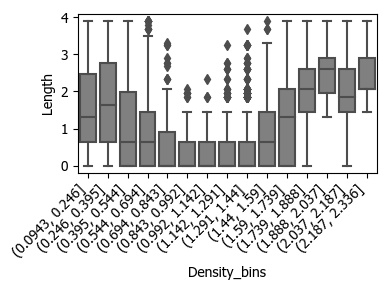

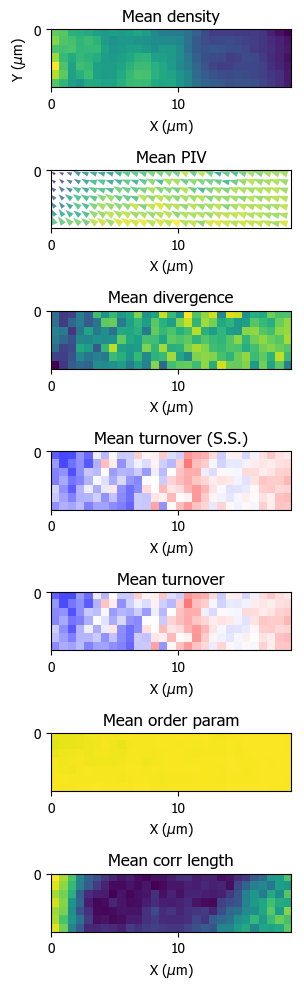

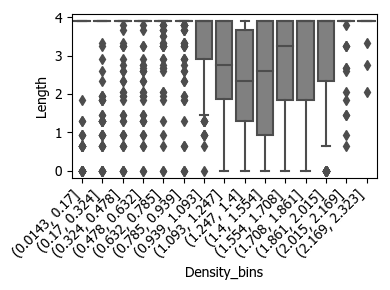

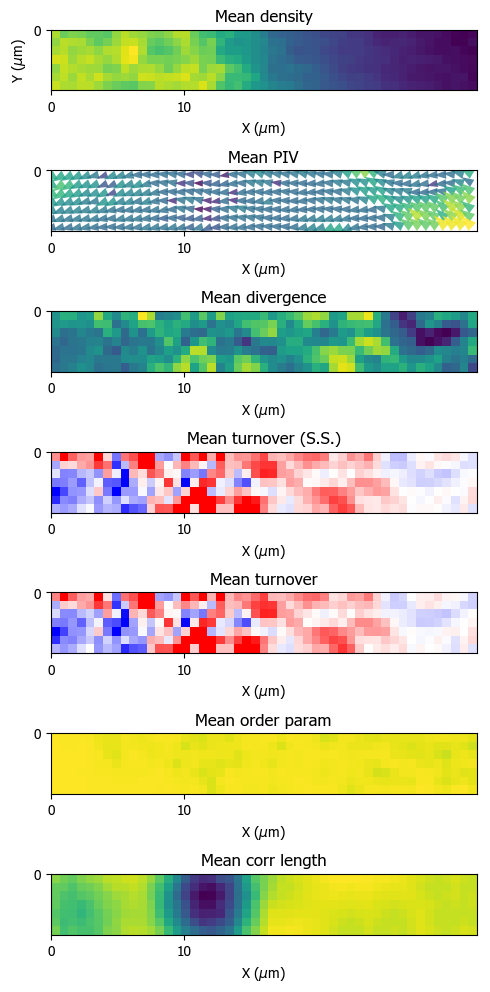

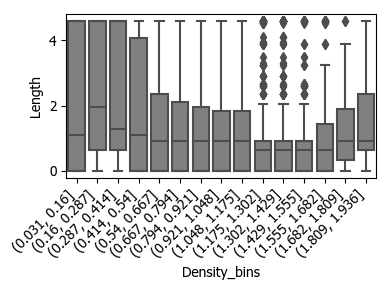

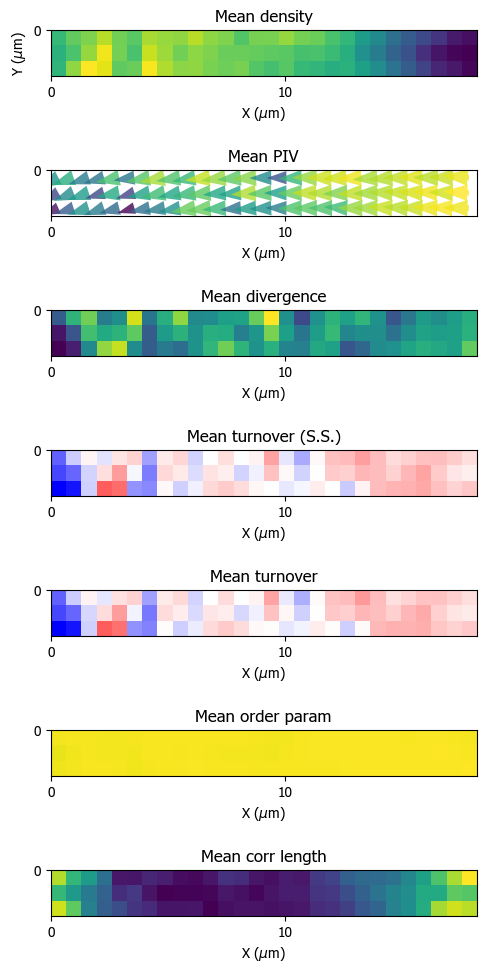

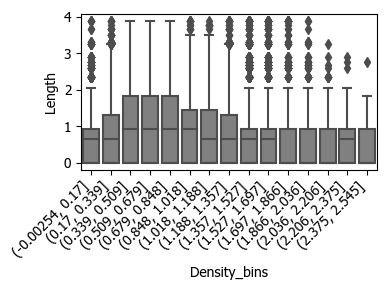

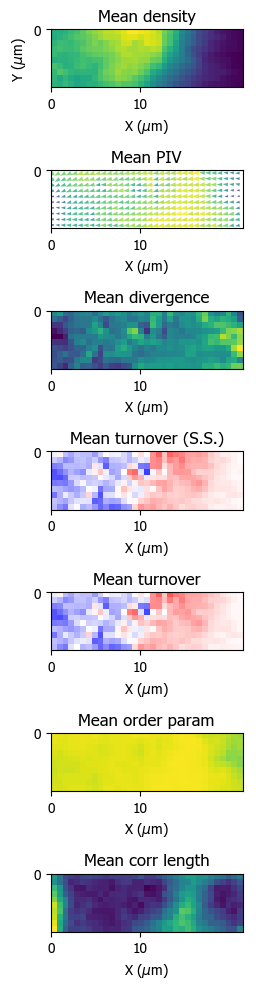

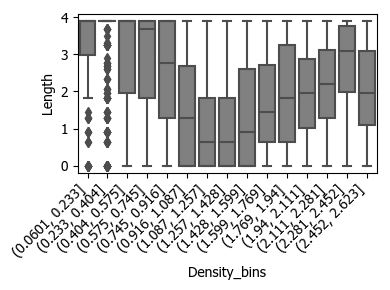

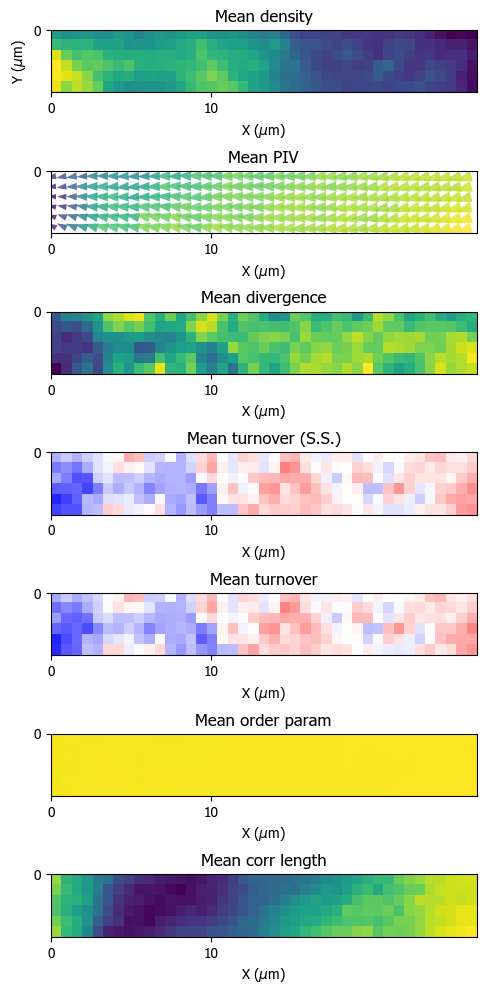

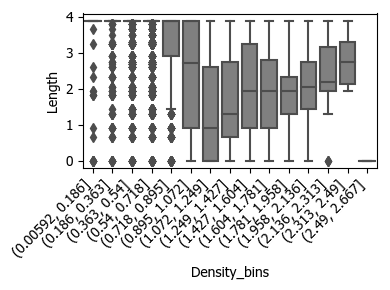

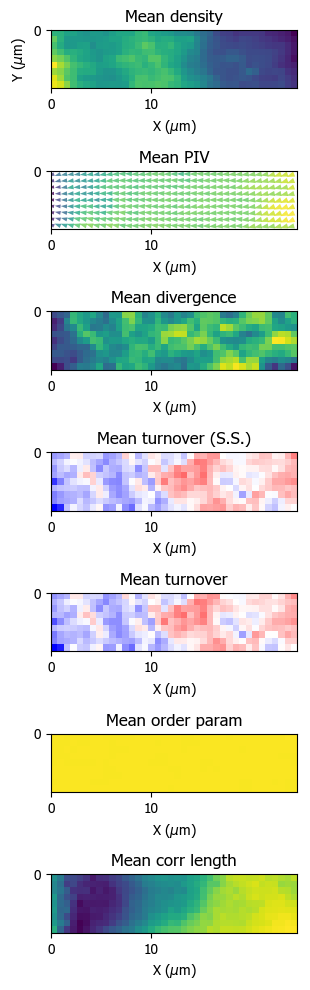

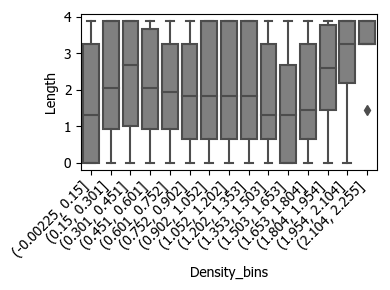

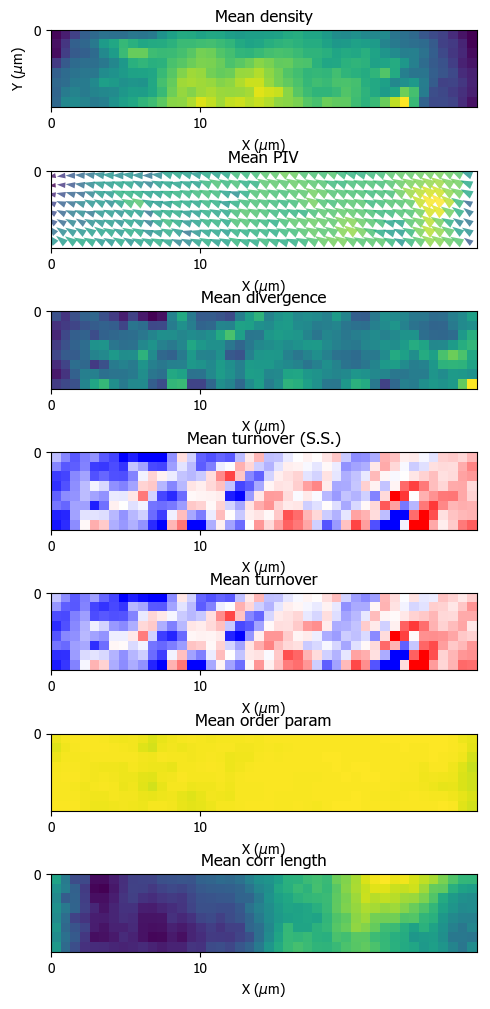

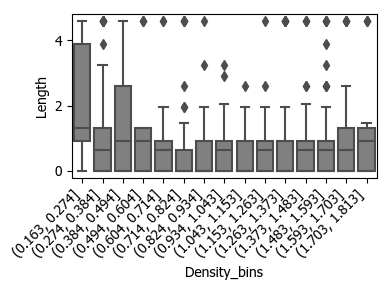

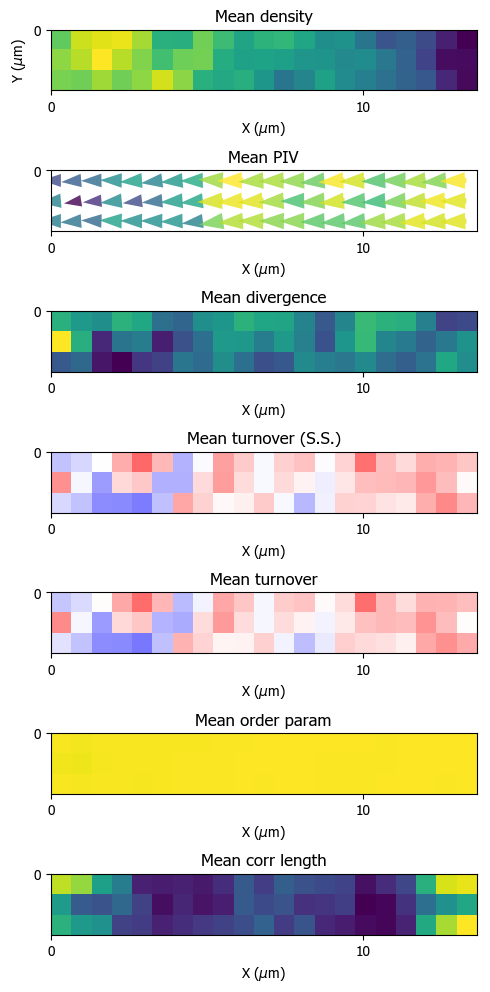

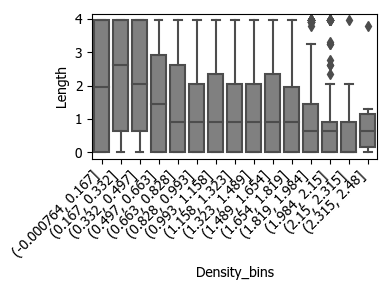

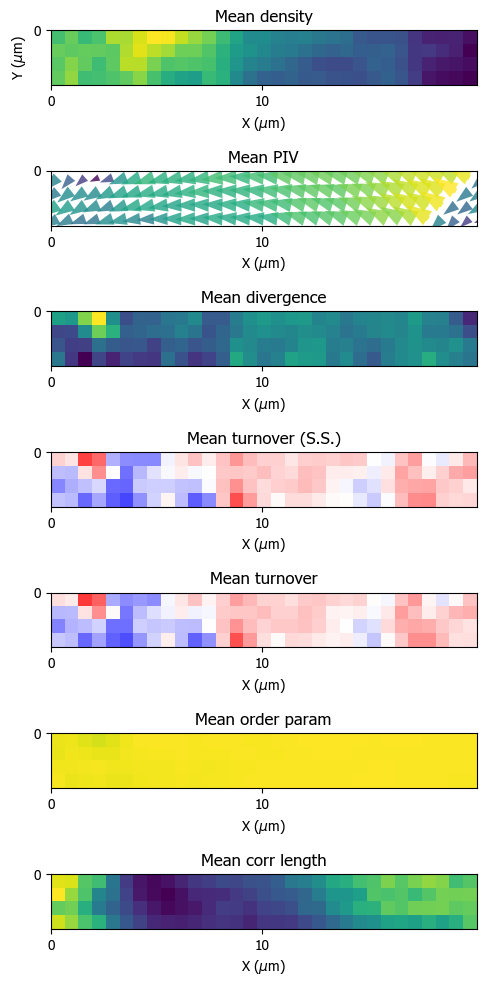

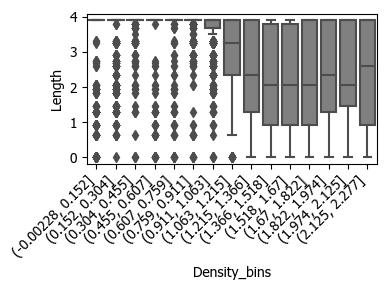

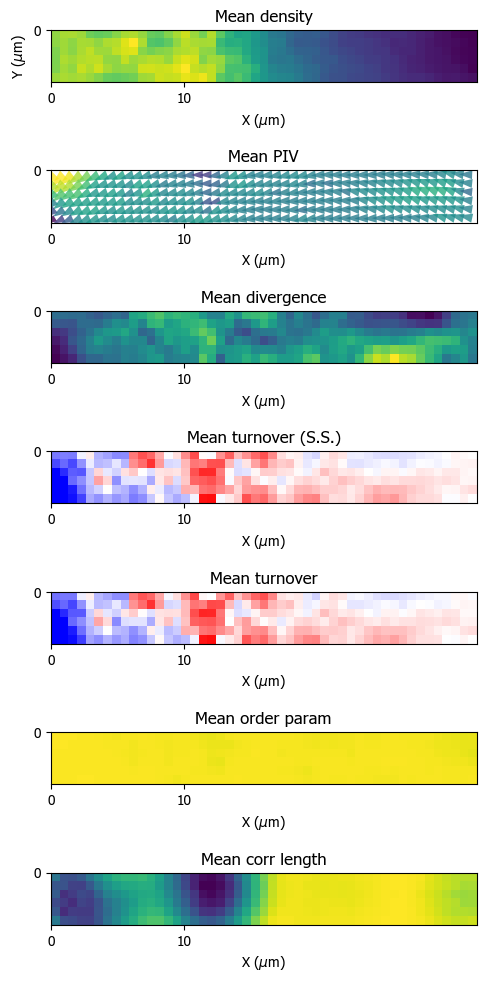

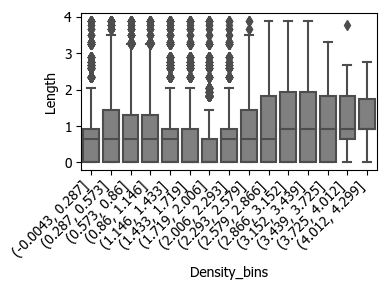

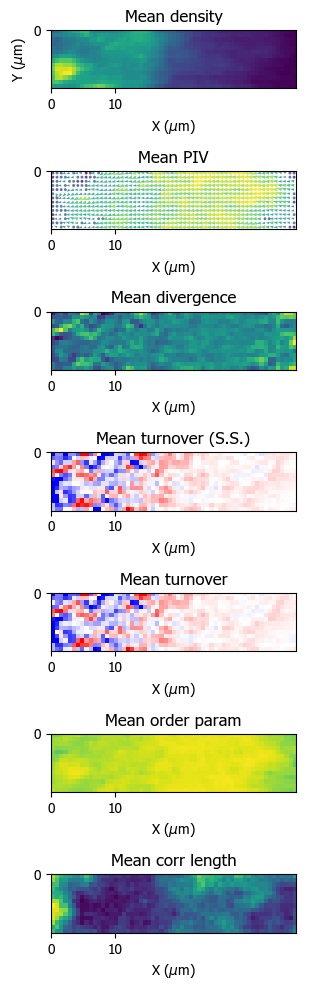

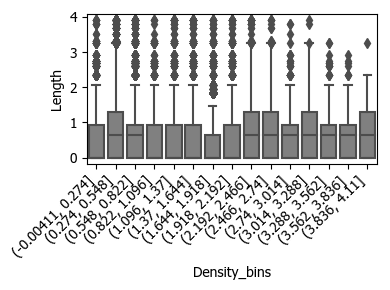

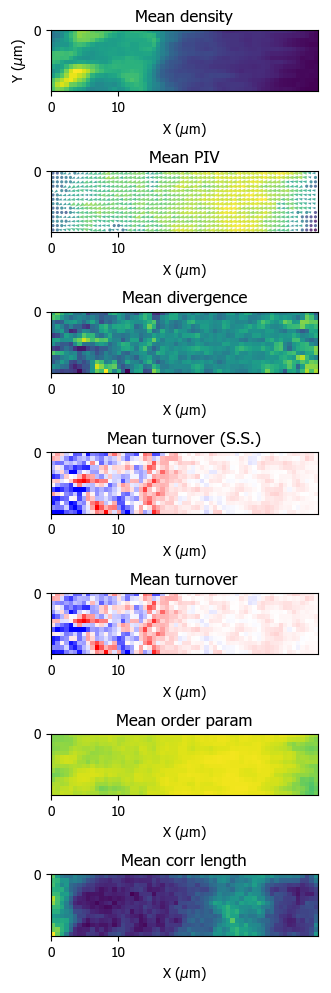

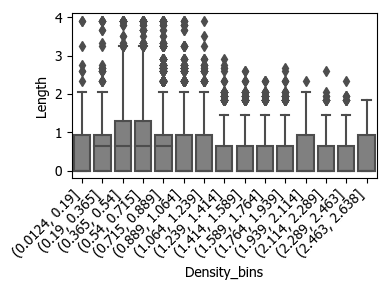

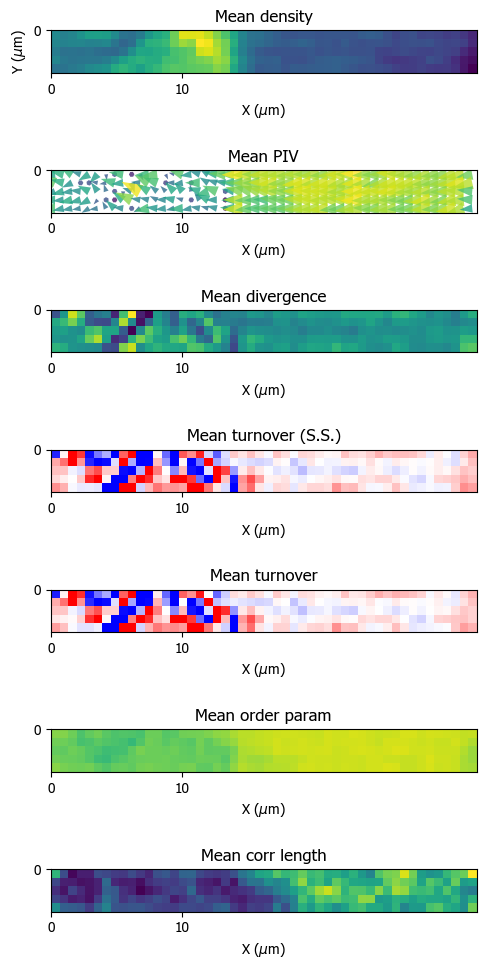

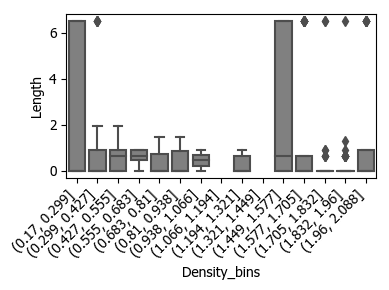

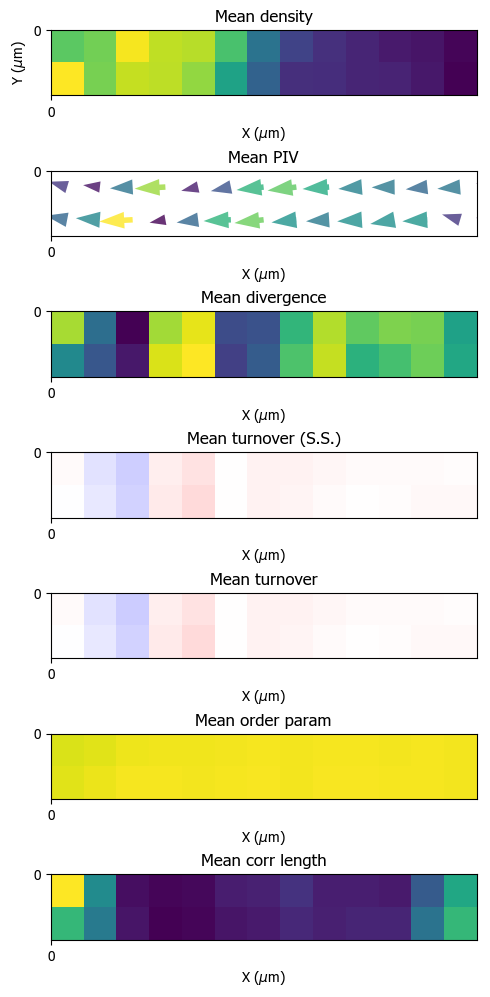

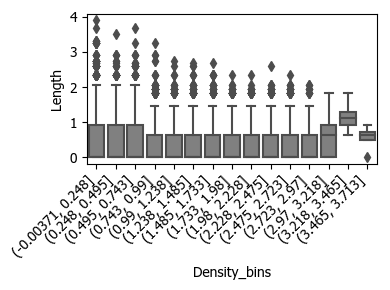

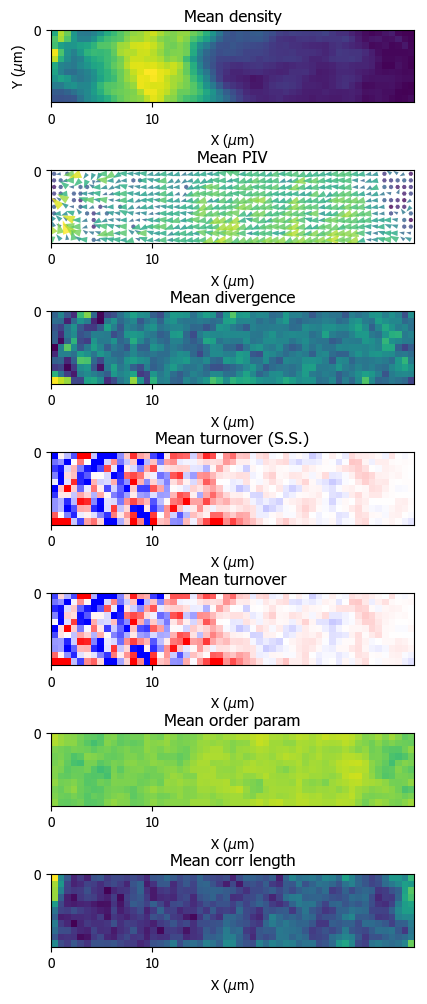

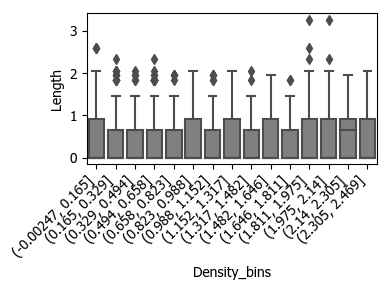

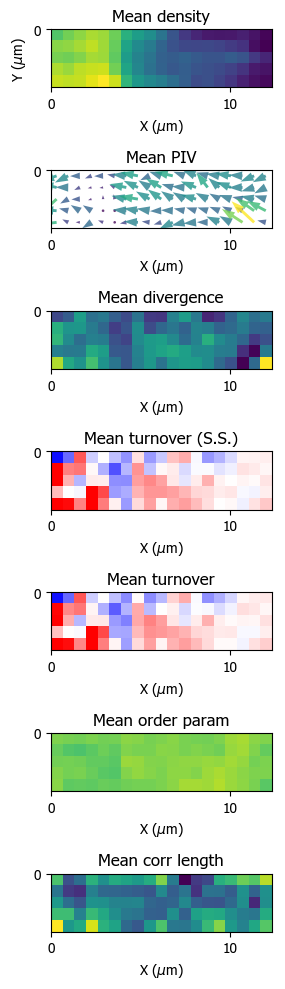

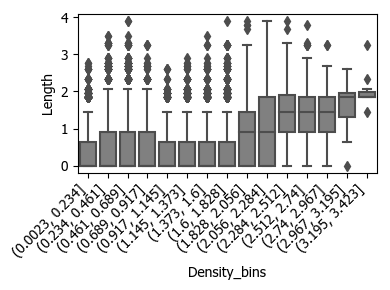

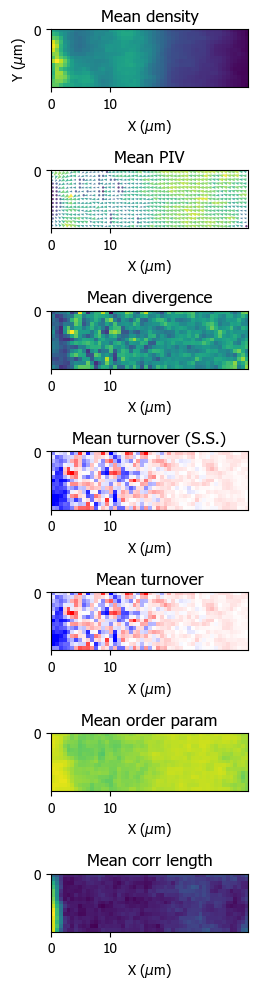

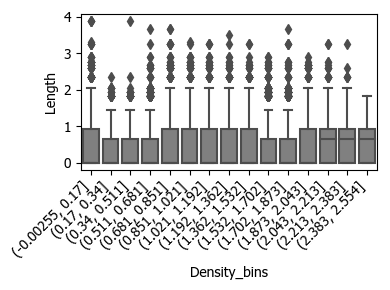

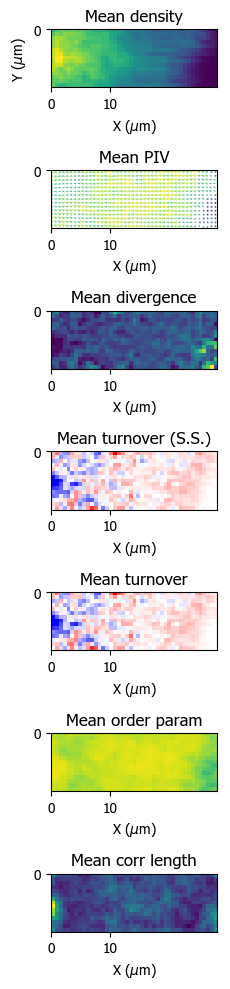

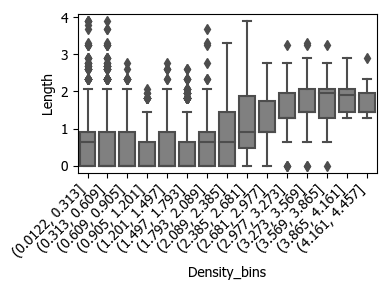

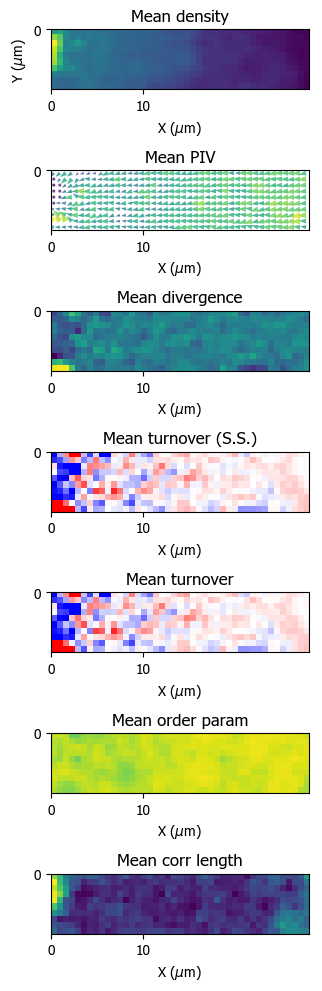

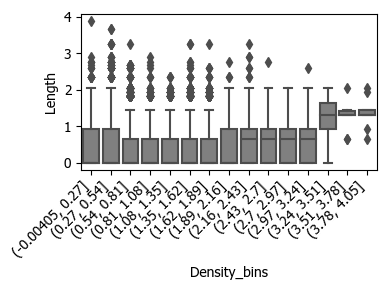

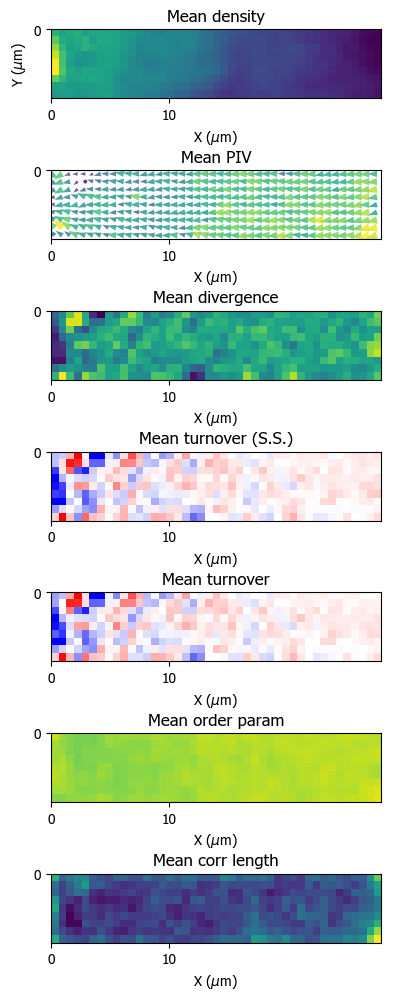

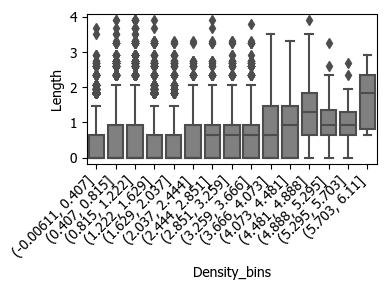

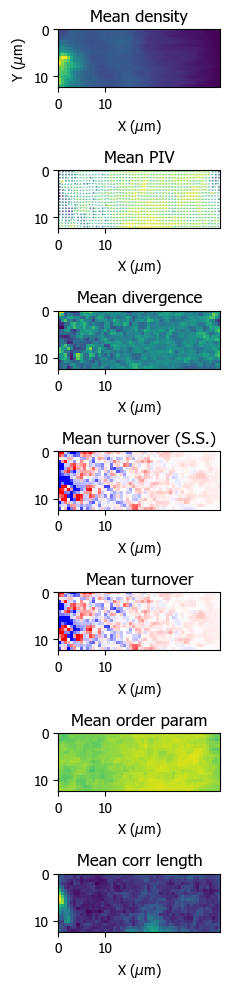

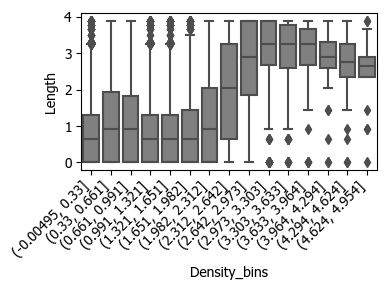

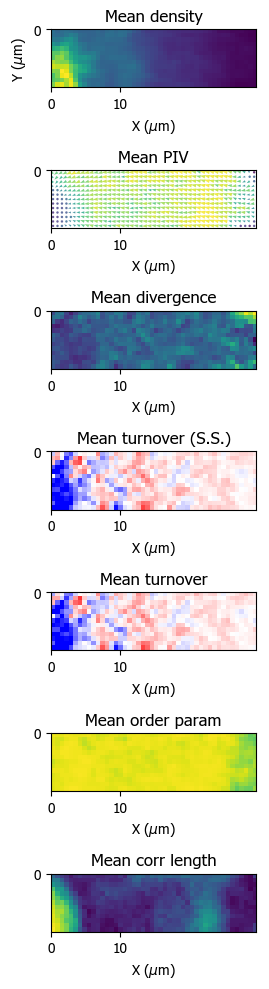

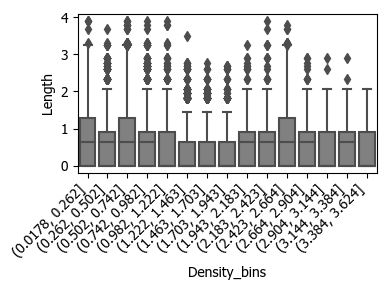

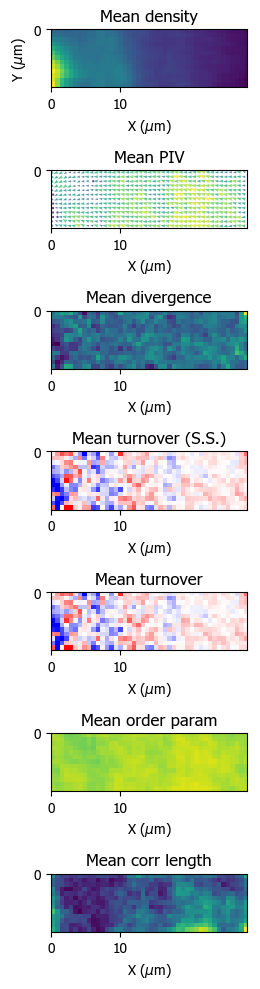

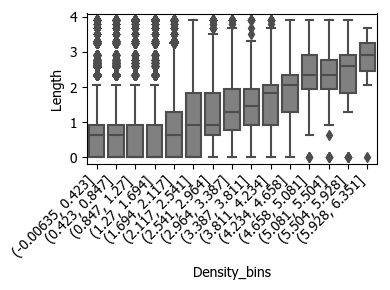

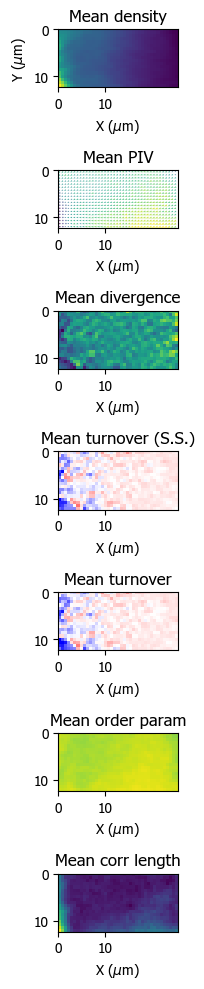

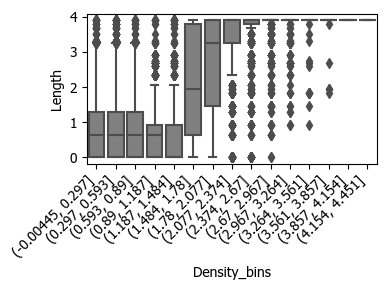

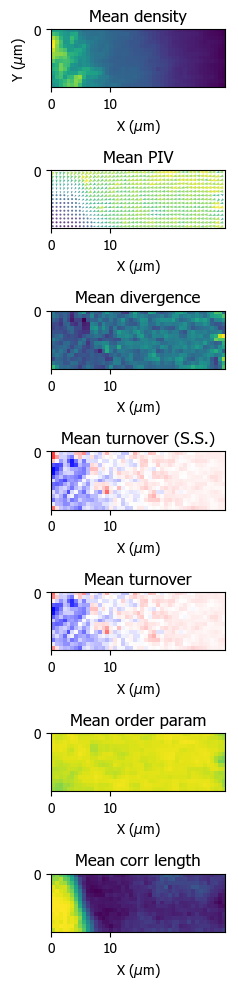

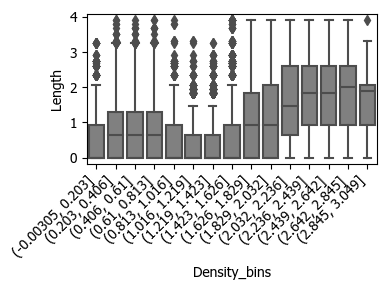

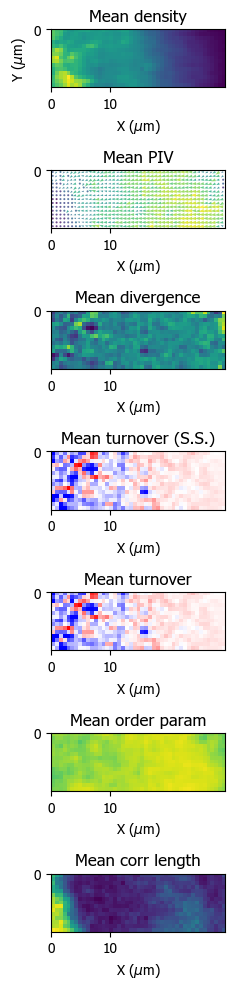

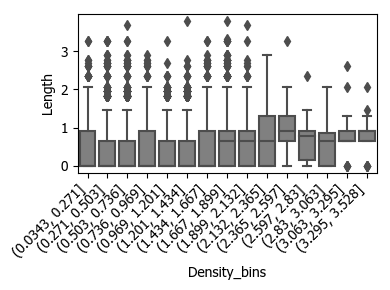

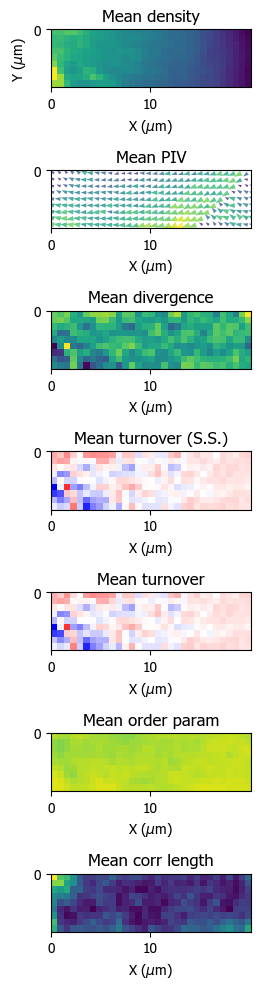

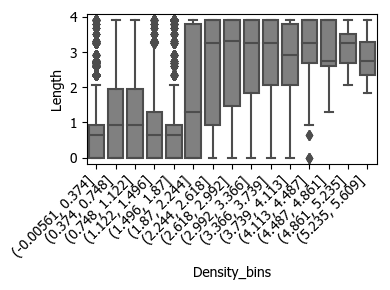

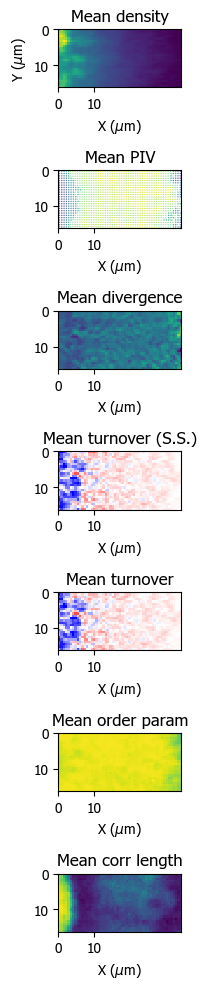

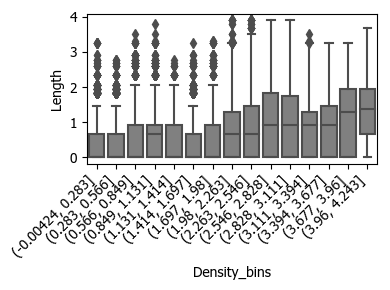

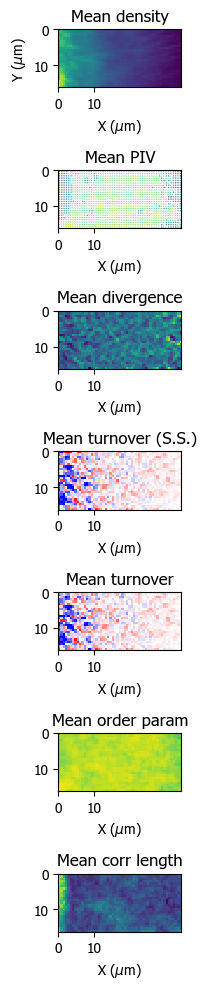

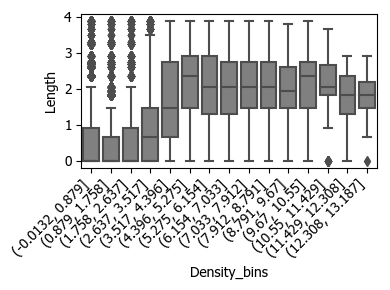

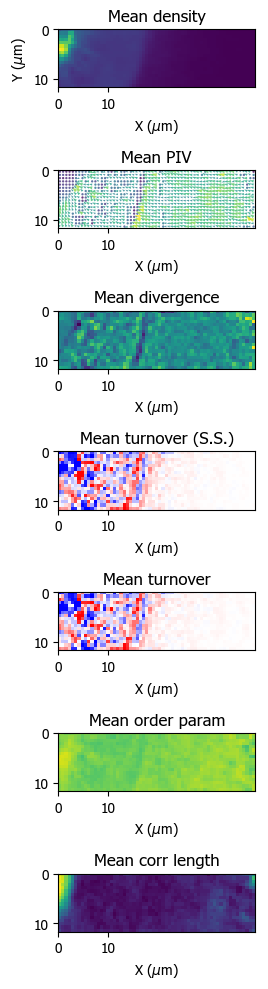

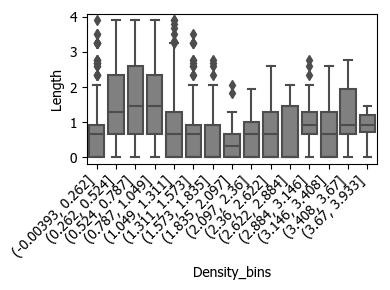

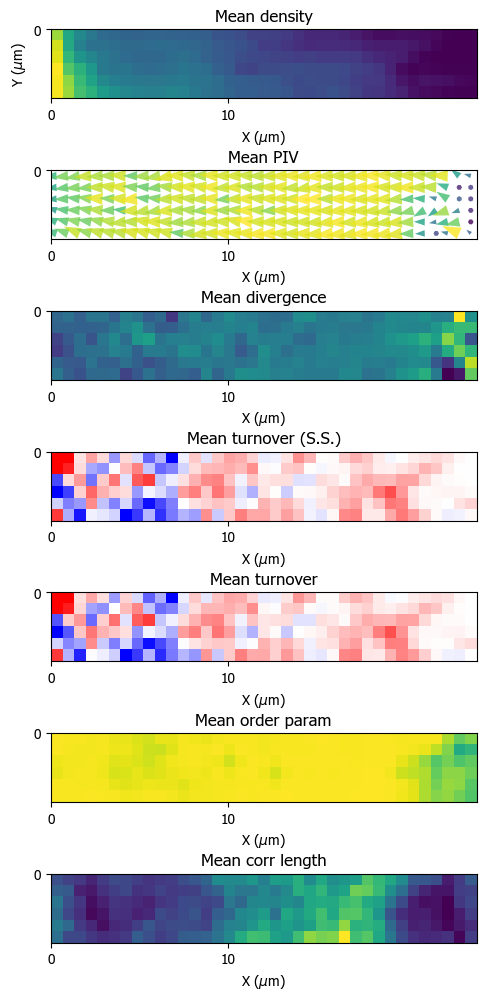

In [3]:
for datafolder in glob("input\\*"):
    name_list, path_list, path_list_den = load_data(datafolder)
    output_path = create_timestamp_path (os.path.basename(datafolder))
    X, Y, ux_array, uy_array, density_array = read_PIV_density_data (name_list, path_list, path_list_den)
    plot_PIV (name_list, path_list, X, Y, ux_array, uy_array, MAX_PLOT, density_array, output_path)
    corr_matrix, corr_distances, order_array = make_correlation_order_array (X, Y, ux_array, uy_array, density_array) 
    corr_lengths = calculate_correlation_lengths (corr_matrix, corr_distances, density_array, output_path)
    den, ux, uy, div, turn, order, corr = plot_summary_bleb(ux_array, uy_array, density_array, corr_lengths, order_array, output_path)
    np.savetxt(datafolder+'\\'+'den.txt', den, fmt='%f')
    np.savetxt(datafolder+'\\'+'ux.txt', ux, fmt='%f')
    np.savetxt(datafolder+'\\'+'uy.txt', uy, fmt='%f')
    np.savetxt(datafolder+'\\'+'div.txt', div, fmt='%f')
    np.savetxt(datafolder+'\\'+'turn.txt', turn, fmt='%f')
    np.savetxt(datafolder+'\\'+'order.txt', order, fmt='%f')
    np.savetxt(datafolder+'\\'+'corr.txt', corr, fmt='%f')

In [4]:
den_list = []
ux_list = []
uy_list = []
div_list = []
turn_list = []
order_list = []
corr_list = []

for datafolder in glob("input\\*"):
    den_list.append(np.loadtxt(datafolder+'\\'+'den.txt'))
    ux_list.append(np.loadtxt(datafolder+'\\'+'ux.txt'))
    uy_list.append(np.loadtxt(datafolder+'\\'+'uy.txt'))
    div_list.append(np.loadtxt(datafolder+'\\'+'div.txt'))
    turn_list.append(np.loadtxt(datafolder+'\\'+'turn.txt'))
    order_list.append(np.loadtxt(datafolder+'\\'+'order.txt'))
    corr_list.append(np.loadtxt(datafolder+'\\'+'corr.txt'))

C:\Users\Juanma\Anaconda3\lib\site-packages\numpy\polynomial\_polybase.py:877: RankWarning: The fit may be poorly conditioned
  res = cls._fit(xnew, y, deg, w=w, rcond=rcond, full=full)
C:\Users\Juanma\Anaconda3\lib\site-packages\numpy\polynomial\_polybase.py:877: RankWarning: The fit may be poorly conditioned
  res = cls._fit(xnew, y, deg, w=w, rcond=rcond, full=full)
C:\Users\Juanma\Anaconda3\lib\site-packages\numpy\polynomial\_polybase.py:877: RankWarning: The fit may be poorly conditioned
  res = cls._fit(xnew, y, deg, w=w, rcond=rcond, full=full)
C:\Users\Juanma\Anaconda3\lib\site-packages\numpy\polynomial\_polybase.py:877: RankWarning: The fit may be poorly conditioned
  res = cls._fit(xnew, y, deg, w=w, rcond=rcond, full=full)
C:\Users\Juanma\Anaconda3\lib\site-packages\numpy\polynomial\_polybase.py:877: RankWarning: The fit may be poorly conditioned
  res = cls._fit(xnew, y, deg, w=w, rcond=rcond, full=full)
C:\Users\Juanma\Anaconda3\lib\site-packages\numpy\polynomial\_polybase

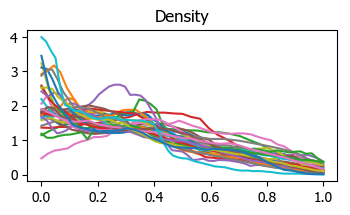

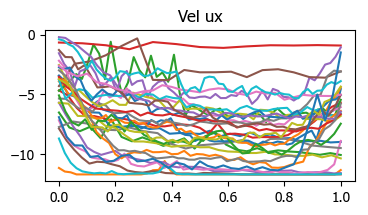

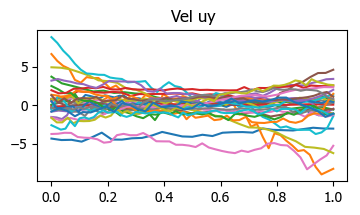

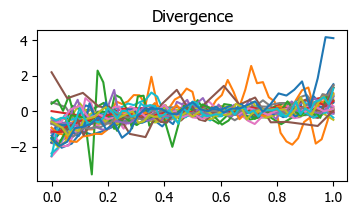

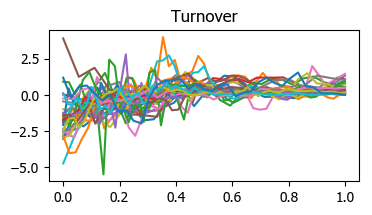

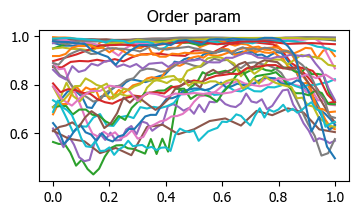

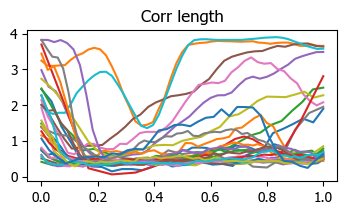

In [5]:
titles = ['Density', 'Vel ux', 'Vel uy', 'Divergence', 'Turnover', 'Order param', 'Corr length']
list_raw = [den_list, ux_list, uy_list, div_list, turn_list, order_list, corr_list]
N_cell = len(den_list)
N_variable = len(list_raw)
out_final = np.zeros((100, N_cell, N_variable))

mpl.rcParams['figure.dpi']= 100
plt.rcParams['figure.figsize'] = [4,2]

for variable in np.arange(N_variable):
    fig, ax = plt.subplots (1, 1)
    for cell in np.arange(N_cell):
        y = np.median(list_raw[variable][cell], axis=0)
        x = np.linspace(0,1,len(y))
        fit_data = Poly.fit(x, y, deg=15)
        out_final[:,cell,variable] = fit_data.linspace()[1]
        plt.plot(x, y)
    ax.set_title(titles[variable])
    plt.savefig(titles[variable]+'.pdf')

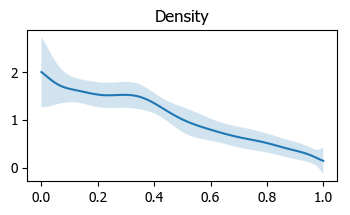

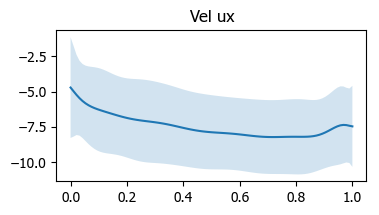

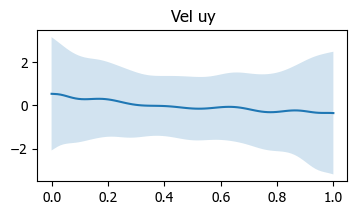

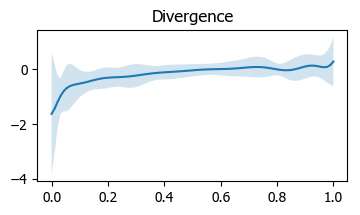

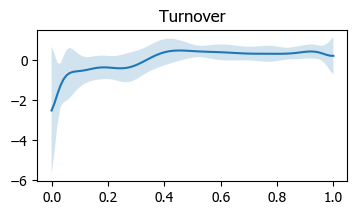

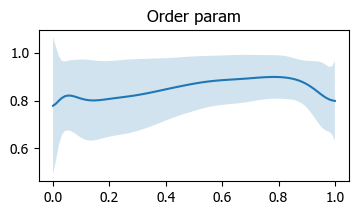

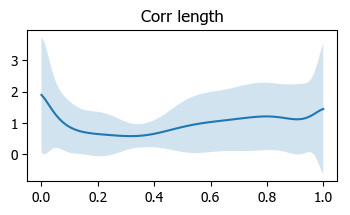

In [6]:
for variable in np.arange(N_variable):
    fig, ax = plt.subplots (1, 1)
    mean = np.mean(out_final[2:97,:,variable], axis=1)
    std = np.std(out_final[2:97,:,variable], axis=1)
    ax.plot(np.linspace(0,1,95), mean)
    ax.fill_between(np.linspace(0,1,95), mean-std, mean+std, alpha=0.2)
    ax.set_title(titles[variable])